In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch.nn.functional as F
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import chain

In [2]:
Battery_list1 = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery1 = np.load('dataset/output/capacity.npy', allow_pickle=True)
Battery1 = Battery1.item()

Battery_list2 = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery2 = np.load('dataset/CALCE.npy', allow_pickle=True)
Battery2 = Battery2.item()

In [3]:
import numpy as np

# Load the dataset
Battery2 = np.load('dataset/CALCE.npy', allow_pickle=True)
Battery2 = Battery2.item()

# Print the keys in the dataset (Battery2)
print("Keys in Battery2:", Battery2.keys())

# Print the details of the data for a specific battery (for example 'CS2_35')
battery_name = 'CS2_35'
if battery_name in Battery2:
    print(f"Data for {battery_name}:")
    print(Battery2[battery_name])  # This will show the full data for 'CS2_35'
else:
    print(f"Battery {battery_name} not found in the dataset.")

Keys in Battery2: dict_keys(['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38'])
Data for CS2_35:
     cycle  capacity       SoH  resistance         CCCT         CVCT
0      1.0  1.126385  0.825175    0.094009  6613.059052  2251.498033
1      2.0  1.126160  0.815965    0.091661  6612.402800  2231.967052
2      3.0  1.125966  0.815977    0.094649  6608.560673  2228.216959
3      4.0  1.118508  0.825194    0.091413  6604.732222  2247.561061
4      5.0  1.117210  0.806900    0.091413  6629.211049  2077.692393
..     ...       ...       ...         ...          ...          ...
877  878.0  0.339218  0.128353    0.121454  1255.711238          NaN
878  879.0  0.330025  0.128343    0.122852  1535.380556  3328.912803
879  880.0  0.330027  0.119175    0.120863  1291.478395  3022.668035
880  881.0  0.320860  0.119175    0.122264  1290.025300  3007.262188
881  882.0  0.320863  0.119174    0.123185  1264.996494  3010.181684

[882 rows x 6 columns]


In [4]:
def build_instances(sequence, window_size):
    # sequence: list of capacity
    x, y = [], []
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]  # 取连续 window_size 个容量值作为输入
        target = sequence[i+window_size]  # 取滑动窗口末尾的容量值作为目标

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)

# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v['capacity'], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)

In [5]:
XtrainCS35 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/XtrainCS35.npy')
YlabelCS35 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/YlabelCS35.npy')
XtrainCS36 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/XtrainCS36.npy')
YlabelCS36 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/YlabelCS36.npy')
XtrainCS37 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/XtrainCS37.npy')
YlabelCS37 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/YlabelCS37.npy')
XtrainCS38 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/XtrainCS38.npy')
YlabelCS38 = np.load('D:/Jupyter/CALCE-main/dataset/saved_arrays/YlabelCS38.npy')

In [6]:
def prepare_data(X, y):
    # 图像归一化（0~255）→ [0,1]
    X = X / 255.0

    # 标签归一化（min-max）
    y_min = y.min()
    y_max = y.max()
    y_norm = (y - y_min) / (y_max - y_min + 1e-8)

    # 转换为 PyTorch tensor
    X = torch.tensor(X, dtype=torch.float32)
    y_norm = torch.tensor(y_norm, dtype=torch.float32)

    return X, y_norm, y_min, y_max

# 分别处理四个电池的数据
XtrainCS35, YlabelCS35, y35_min, y35_max = prepare_data(XtrainCS35, YlabelCS35)
XtrainCS36, YlabelCS36, y36_min, y36_max = prepare_data(XtrainCS36, YlabelCS36)
XtrainCS37, YlabelCS37, y37_min, y37_max = prepare_data(XtrainCS37, YlabelCS37)
XtrainCS38, YlabelCS38, y38_min, y38_max = prepare_data(XtrainCS38, YlabelCS38)

def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)
        
    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v['capacity'], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(np.mean((y_predict - y_test) ** 2))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform  # 传入 transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.image_paths[idx]  # 获取图像数据

        # 确保图像是 numpy 数组
        if isinstance(image, np.ndarray):
            # 去除多余的维度，确保图像是 2D 或 3D（height, width, channels）
            image = np.squeeze(image)  # 删除不必要的维度
            # 如果是浮动值，确保在 [0, 255] 范围内
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            # 转换为 PIL 图像
            image = Image.fromarray(image)  
        elif isinstance(image, Image.Image):
            pass  # 如果已经是 PIL 图像，直接使用

        label = self.labels[idx]

        # 应用 transform
        if self.transform:
            image = self.transform(image)

        # 确保图像是 Tensor
        if not isinstance(image, torch.Tensor):
            raise TypeError(f"Expected image to be a Tensor but got {type(image)}")

        # 确保 label 是 Tensor
        label = torch.tensor(label, dtype=torch.float32)  # 将 label 转换为 Tensor
        return image, label

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# TSA 模块定义（多头自注意力模块）
class TSA(nn.Module):
    def __init__(self, d_model, num_heads, c, L):
        super(TSA, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.c = c
        self.L = L

        self.msa_dim = nn.MultiheadAttention(d_model, num_heads)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Ensure x has shape (L, B, D), i.e., (time_steps, batch_size, d_model)
        x_time = x.permute(1, 0, 2)  # Reshape to (L, B, D)
        
        # Perform the attention operation
        aggregated, _ = self.msa_dim(x_time, x_time, x_time)  # Output shape: (L, B, D)
        aggregated = self.dropout(aggregated)  # Apply dropout
        aggregated = self.norm(x_time + aggregated)  # Residual connection + layer norm

        return aggregated.permute(1, 0, 2)  # Reshape back to (B, L, D)


# CNN + LSTM + TSA 网络
class CNN_LSTM_TSA_Net(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=1, mode='LSTM', d_model=32, num_heads=4, c=1, L=10):
        super(CNN_LSTM_TSA_Net, self).__init__()

        # 定义卷积层
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1),  # 卷积层1
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                                 # 池化层1
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 卷积层2
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)                                  # 池化层2
        )
        
        # 计算LSTM的输入维度
        lstm_input_size = 32  # 对应卷积后的输出通道数

        # 定义RNN层
        if mode == 'LSTM':
            self.cell = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'GRU':
            self.cell = nn.GRU(input_size=lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # 用于调整残差的线性层
        self.residual_transform = nn.Linear(lstm_input_size, hidden_dim)

        # 定义TSA模块
        self.tsa = TSA(d_model=d_model, num_heads=num_heads, c=c, L=L)

        # 定义线性层
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):  # x shape: (batch_size, seq_len, 4)
        x = x.permute(0, 2, 1)  # (B, 4, L)

        cnn_out = self.cnn(x)  # (B, 32, L')

        tsa_input = cnn_out.transpose(1, 2)  # (B, L', 32)

        tsa_out = self.tsa(tsa_input)  # (B, L', 32)
            
        lstm_input = tsa_out
        lstm_out, _ = self.cell(lstm_input)

        residual = self.residual_transform(cnn_out.transpose(1, 2))

        lstm_out = lstm_out + residual

        out = self.linear(lstm_out[:, -1, :])

        return out


class CNN_LSTM_Model(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Model, self).__init__()

        # CNN部分
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 → 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 → 8x8
            nn.BatchNorm2d(128)
        )

        self.feature_dim = 128 * 8 * 8

        # LSTM部分
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )

        # 标签回归分支
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W).permute(0, 3, 1, 2)

        features = self.cnn(x)                  # (B*T, 128, 8, 8)
        features = features.reshape(B, T, -1)

        lstm_out, _ = self.lstm(features)       # (B, T, 256)
        last_hidden = lstm_out[:, -1, :]        # (B, 256)

        y_pred = self.fc(last_hidden)           # (B, 1)
        
        return y_pred

# 运行模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = CNN_LSTM_Model().to(device)

class FusionModel(nn.Module):
    def __init__(self, model_img, model_feat):
        super(FusionModel, self).__init__()
        self.model_img = model_img
        self.model_feat = model_feat

        # 可训练权重，初始化为 0.5
        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self, inputs):
        img_input, feat_input=inputs
        # 分支1：图像序列模型（返回 y_pred, x_pred_next）
        y1 = self.model_img(img_input)
        # 分支2：时序特征模型（只返回 y_pred）
        y2 = self.model_feat(feat_input)      # y2 shape: (B, 1)
        
        # Sigmoid 保证 alpha 在 (0,1)
        alpha = torch.sigmoid(self.alpha)

        # 加权融合
        y_fused = alpha * y1 + (1 - alpha) * y2

        return y_fused

# 运行模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModel(CNN_LSTM_Model(),CNN_LSTM_TSA_Net()).to(device)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


def get_time_data_multifeature(battery_id, time_data_dict, window_size, features):
    """
    对单个电池，针对多个特征构造滑动窗口数据
    返回: 
        x_multi: np.array (N_samples, window_size, num_features)
        y_label: np.array (N_samples,)
    """
    x_list = []
    y_label = None
    for feature in features:
        seq = time_data_dict[battery_id][feature]
        x_f, y_f = build_instances(seq, window_size)
        x_list.append(x_f)
        if y_label is None:
            y_label = y_f
    x_multi = np.stack(x_list, axis=-1)  # (N_samples, window_size, num_features)
    return x_multi, y_label

def train_multimodal_model_leave_one(
    model, 
    image_data_dict, 
    time_data_dict, 
    Ylabel_dict, 
    window_size=16, 
    batch_size=32, 
    num_epochs=40,
    features=['capacity', 'SoH', 'resistance', 'CCCT'],
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    all_batteries = list(image_data_dict.keys())
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        for test_battery in all_batteries:
            # 训练集是除test_battery外的所有电池数据合并
            train_img_list, train_time_list, train_label_list = [], [], []

            for battery_id in all_batteries:
                if battery_id == test_battery:
                    continue
                # 图像数据
                img_data = image_data_dict[battery_id]   # (N_img, ...)
                y_img = Ylabel_dict[battery_id]

                # 时序多特征数据构造
                x_time_multi, y_time = get_time_data_multifeature(battery_id, time_data_dict, window_size, features)

                # 一般假设滑动窗口个数跟图像数量相同，如果不等，截取一致数量
                n_samples = min(len(img_data), len(x_time_multi), len(y_img), len(y_time))
                train_img_list.append(img_data[:n_samples])
                train_time_list.append(x_time_multi[:n_samples])
                train_label_list.append(y_img[:n_samples])

            # 合并所有训练电池数据
            train_img_all = np.concatenate(train_img_list, axis=0)
            train_time_all = np.concatenate(train_time_list, axis=0)
            train_label_all = np.concatenate(train_label_list, axis=0)

            # 转为Tensor
            img_tensor = torch.tensor(train_img_all).float().to(device)
            time_tensor = torch.tensor(train_time_all).float().to(device)
            label_tensor = torch.tensor(train_label_all).float().to(device)

            # 训练批次
            dataset = TensorDataset(img_tensor, time_tensor, label_tensor)
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            for img_batch, time_batch, label_batch in loader:
                optimizer.zero_grad()
                output = model([img_batch, time_batch]).squeeze(-1)
                loss = criterion(output, label_batch)
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

    return model, train_losses


# 假设 Battery2 中的时序数据是按电池名（例如 'CS2_35', 'CS2_36' 等）存储的，使用这个字典结构传递数据
time_data_dict = {
    'CS2_35': Battery2['CS2_35'],
    'CS2_36': Battery2['CS2_36'],
    'CS2_37': Battery2['CS2_37'],
    'CS2_38': Battery2['CS2_38']
}

image_data_dict = {
    'CS2_38': XtrainCS38,
    'CS2_37': XtrainCS37,
    'CS2_36': XtrainCS36
}

Ylabel_dict = {
    'CS2_38': YlabelCS38,
    'CS2_37': YlabelCS37,
    'CS2_36': YlabelCS36
}
total_epochs = 40      # 每次训练的轮数
repeat_times = 5       # 连续训练次数

all_train_losses = []

for run in range(repeat_times):
    print(f"\n=== Training Run {run+1}/{repeat_times} ===")
    model, train_losses = train_multimodal_model_leave_one(
        model=model,                   # 使用上一次训练后的模型
        image_data_dict=image_data_dict,
        time_data_dict=Battery2,
        Ylabel_dict=Ylabel_dict,
        window_size=16,
        batch_size=64,
        num_epochs=total_epochs
    )
    all_train_losses.append(train_losses)

all_train_losses_concat = np.concatenate(all_train_losses)

Epoch 1/40, Loss: 0.193940
Epoch 2/40, Loss: 0.002341
Epoch 3/40, Loss: 0.002185
Epoch 4/40, Loss: 0.001668
Epoch 5/40, Loss: 0.002115
Epoch 6/40, Loss: 0.001319
Epoch 7/40, Loss: 0.001145
Epoch 8/40, Loss: 0.001096
Epoch 9/40, Loss: 0.001077
Epoch 10/40, Loss: 0.001053
Epoch 11/40, Loss: 0.001035
Epoch 12/40, Loss: 0.000995
Epoch 13/40, Loss: 0.001032
Epoch 14/40, Loss: 0.000984
Epoch 15/40, Loss: 0.000984
Epoch 16/40, Loss: 0.000998
Epoch 17/40, Loss: 0.000959
Epoch 18/40, Loss: 0.001011
Epoch 19/40, Loss: 0.001114
Epoch 20/40, Loss: 0.001229
Epoch 21/40, Loss: 0.001009
Epoch 22/40, Loss: 0.001003
Epoch 23/40, Loss: 0.001080
Epoch 24/40, Loss: 0.001173
Epoch 25/40, Loss: 0.001099
Epoch 26/40, Loss: 0.001144
Epoch 27/40, Loss: 0.000982
Epoch 28/40, Loss: 0.001035
Epoch 29/40, Loss: 0.001295
Epoch 30/40, Loss: 0.000990
Epoch 31/40, Loss: 0.000968
Epoch 32/40, Loss: 0.000985
Epoch 33/40, Loss: 0.001205
Epoch 34/40, Loss: 0.001174
Epoch 35/40, Loss: 0.001406
Epoch 36/40, Loss: 0.000929
E

In [1]:
def predict_multimodal_model_leave_one_clean(
    model, 
    test_battery_id, 
    image_data_dict, 
    time_data_dict, 
    Ylabel_dict, 
    window_size=16, 
    batch_size=32,
    rated_capacity=1.1,
    features=['capacity', 'SoH', 'resistance', 'CCCT'],
    pred_threshold=0.8,
    save_path="prediction_boxplot_clean.png",
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    model.to(device)
    model.eval()

    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    image_data = image_data_dict[test_battery_id]
    y_label = Ylabel_dict[test_battery_id]

    # 构造时域滑动窗口数据
    def get_time_data_multifeature(battery_id, time_data_dict, window_size, features):
        data = time_data_dict[battery_id]
        feature_matrix = np.array([data[f].values for f in features]).T
        x_list = [feature_matrix[i:i+window_size] for i in range(len(feature_matrix) - window_size)]
        return np.array(x_list)

    x_time = get_time_data_multifeature(test_battery_id, time_data_dict, window_size, features)

    n_samples = min(len(image_data), len(x_time), len(y_label))
    x_img = image_data[:n_samples]
    x_time = x_time[:n_samples]
    y_true = y_label[:n_samples]

    x_img_tensor = torch.tensor(x_img).float().to(device)
    x_time_tensor = torch.tensor(x_time).float().to(device)
    y_true_tensor = torch.tensor(y_true).float().to(device)

    # 预测
    all_preds = []
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            img_batch = x_img_tensor[i:i+batch_size]
            time_batch = x_time_tensor[i:i+batch_size]
            output = model([img_batch, time_batch]).squeeze(-1)
            all_preds.append(output.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    y_true = y_true_tensor[:len(preds)].cpu().numpy()

    preds_percent = preds / rated_capacity * 100
    y_true_percent = y_true / rated_capacity * 100

    # 只选预测值大于阈值的部分
    mask = preds > pred_threshold
    preds_filtered = preds_percent[mask]
    y_true_filtered = y_true_percent[mask]

    mape_score = mape(y_true_filtered, preds_filtered)
    rmspe_score = np.sqrt(np.mean(((y_true_filtered - preds_filtered) / y_true_filtered) ** 2)) * 100

    # 绘图
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['font.size'] = 10

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    box = ax.boxplot(
        [mape_score, rmspe_score],
        labels=['MAPE', 'RMSPE'],
        patch_artist=True,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(marker='o', color='red', markersize=5, alpha=0.5)
    )

    colors = ['#aec7e8', '#98df8a']  # 浅蓝、浅绿
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel('Error (%)', fontsize=12, fontname='Arial')
    ax.set_title(f'{test_battery_id} Prediction Errors', fontsize=14, fontname='Arial')
    ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches='tight', facecolor='white')
    plt.show()

    return {
        'preds_percent': preds_percent,
        'y_true_percent': y_true_percent,
        'mape': mape_score,
        'rmspe': rmspe_score
    }

# 调用
results = predict_multimodal_model_leave_one_clean(
    model=model,
    test_battery_id='CS2_35',
    image_data_dict=image_data_dict,
    time_data_dict=Battery2,
    Ylabel_dict=Ylabel_dict,
    window_size=16,
    batch_size=32,
    rated_capacity=1.1,
    pred_threshold=0.6,
    save_path="D:/Jupyter/CALCE-main/dataset/35boxplot_clean.png"
)

print("MAPE:", results['mape'], "%")
print("RMSPE:", results['rmspe'], "%")

NameError: name 'torch' is not defined

C:\Users\23896\AppData\Local\Temp\ipykernel_6716\3494228543.py:15: RuntimeWarning: divide by zero encountered in divide
  rel_error = np.abs(preds - y_true) / y_true


Figure saved to: D:/Jupyter/CALCE-main/dataset/CS2_35_SoH_ablation.png


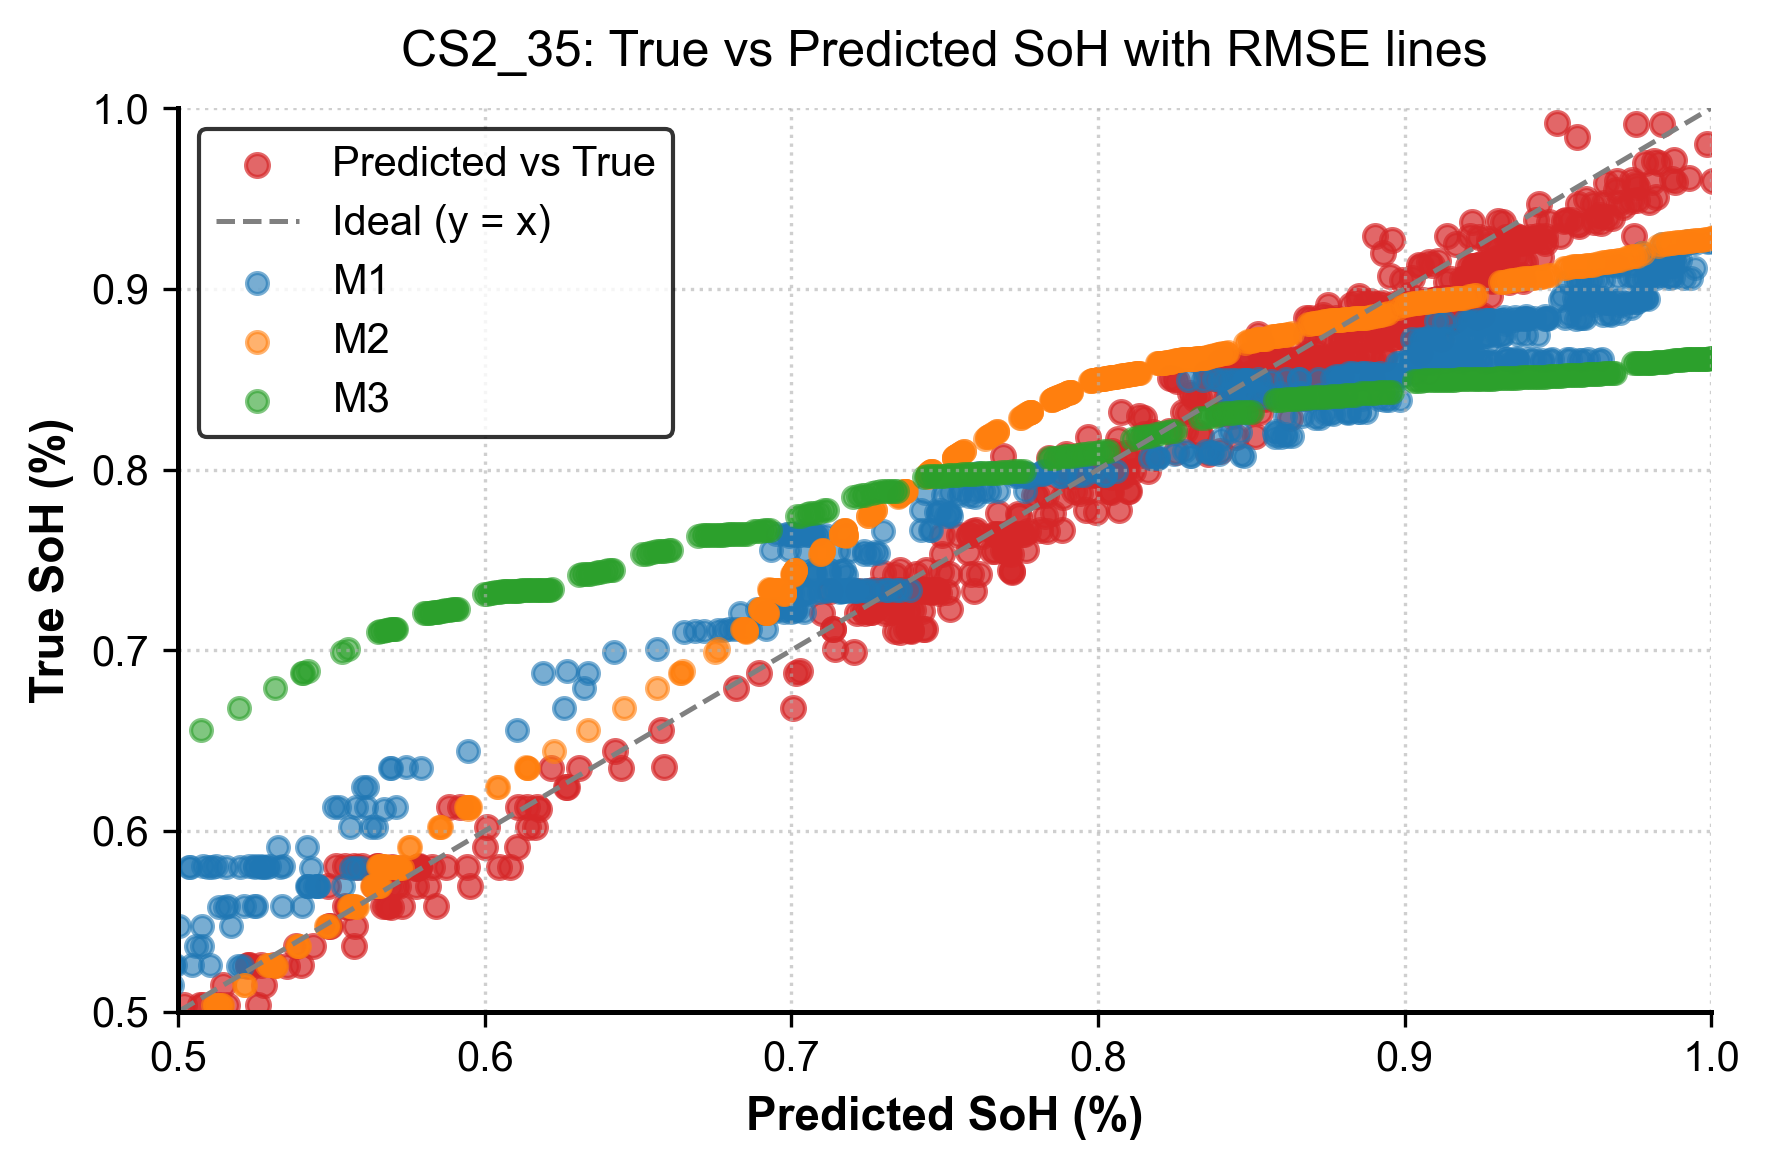

In [27]:
def scatter_pred_vs_true_clean(y_true, preds, 
                               title="True SoH vs Predicted SoH",
                               soh_range=(0.5, 1.0),
                               save_path=None):
    import numpy as np
    import matplotlib.pyplot as plt

    y_true = np.array(y_true)
    preds = np.array(preds)

    # SCI 风格设置
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['axes.labelsize'] = 11
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['figure.titlesize'] = 12
    plt.rcParams['figure.titleweight'] = 'bold'

    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

    # 散点图
    ax.scatter(preds, y_true,
               color='#1f77b4',  # 蓝色
               marker='o',
               alpha=0.7,
               s=30,
               label='Predicted vs True')

    # 理想线 y = x
    ax.plot([soh_range[0], soh_range[1]], [soh_range[0], soh_range[1]],
            linestyle='--', color='gray', linewidth=1.2,
            label='Ideal (y = x)')

    ax.set_xlim(soh_range)
    ax.set_ylim(soh_range)
    ax.set_xlabel("Predicted SoH (%)", fontweight='bold')
    ax.set_ylabel("True SoH (%)", fontweight='bold')
    ax.set_title(title, pad=10)

    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(frameon=True, edgecolor='black', loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    else:
        plt.show()

scatter_pred_vs_true_clean(y_true, preds,
                           title="CS2_35: True vs Predicted SoH",
                           save_path="D:/Jupyter/CALCE-main/dataset/CS2_35_SoH_clean.png")
